# **train.csv**
- DataFrame info

```plaintext
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):

 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
- 0   transaction_id          1216553 non-null  int64
  - ex 0
  - 제거. 예측에 크게 영향을 미치지 않는 단순 식별자이므로 제거해도 무방.
- 1   apartment_id            1216553 non-null  int64  
  - 아파트 아이디 | ex) 7622
  - 유지. 아파트의 고유 ID로, 아파트마다 가격 차이가 있을 수 있으므로 유지하는 것이 좋을 수 있음.
- 2   city                    1216553 non-null  object
  - 도시 | ex) 서울특별시
  - 유지. 
- 3   dong                    1216553 non-null  object 
  - 동 | ex) 신교동
  - 유지.
- 4   jibun                   1216553 non-null  object 
  - 지번 | ex) 6-13
  - 제거. 너무 과하게 디테일함.
- 5   apt                     1216553 non-null  object 
  - 아파트 단지 이름 | ex) 신현(101동)
  - 유지.
- 6   addr_kr                 1216553 non-null  object 
  - 주소 | ex) 신교동 6-13 신현(101동)
  - 제거. addr_kr = city + dong + jibun + apt
- 7   exclusive_use_area      1216553 non-null  float64
  - 전용면적 | ex) 84.82
  - 유지. 아파트의 전용 면적은 부동산 가격에 중요한 변수이므로 유지.
- 8   year_of_completion      1216553 non-null  int64  
  - 설립일자 | ex) 2002
  - 유지. 건축 연도는 아파트의 나이를 계산하는 데 사용될 수 있으므로 유지.
- 9   transaction_year_month  1216553 non-null  int64
  - 거래년월 | ex) 200801
  - 제거 후 변경 (transaction_year)
  - 제거 후 변경 (transaction_month)
- 10  transaction_date        1216553 non-null  object 
  - 거래날짜 | ex) 21~31
  - 제거. 유의미한 데이터는 아닌 것 같음.
- 11  floor                   1216553 non-null  int64  
  - 층 | ex) 2
  - 유지
- 12  transaction_real_price  1216553 non-null  int64  
  - 실거래가(만원 단위) | ex) 37500
  - 유지
dtypes: float64(1), int64(6), object(6)
```

# 2024.10.8 00:20
- train.csv 로 훈련한 LinearRegression 모델
  - 성능
    - Validation RMSE: 9912.66
    - Test RMSE: 9776.23

=== 데이터 타입 확인 ===
transaction_id              int64
apartment_id                int64
city                       object
dong                       object
jibun                      object
apt                        object
addr_kr                    object
exclusive_use_area        float64
year_of_completion          int64
transaction_year_month      int64
transaction_date           object
floor                       int64
transaction_real_price      int64
dtype: object

=== train_df.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 1216553 entries, 1111339 to 532104
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5 

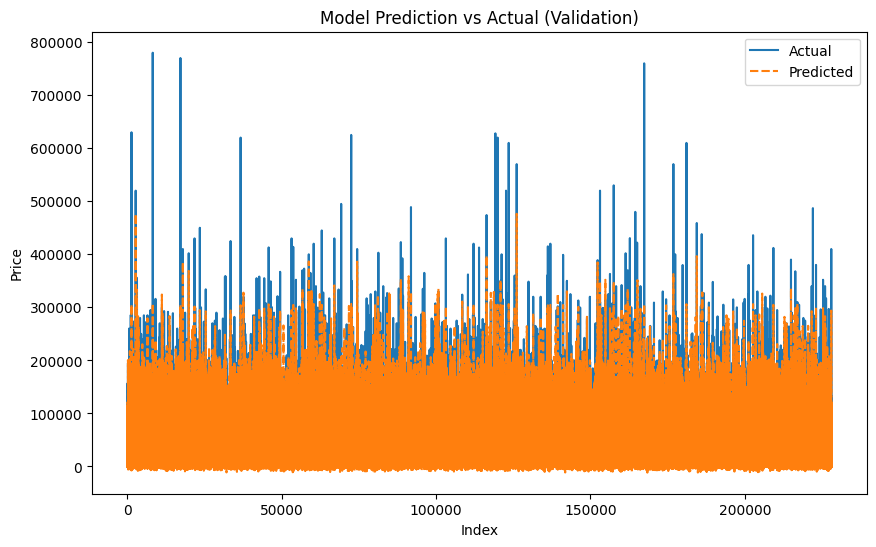

In [3]:
# 패키지/라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# 데이터 불러오기
# train_modified.csv 는 utils 폴더의 python 파일들로, train.csv에 각종 열들을 추가한 것.
df = pd.read_csv("../../dataset/train.csv", encoding="utf-8")

# 데이터 타입 확인
print("=== 데이터 타입 확인 ===")
print(df.dtypes)

# 데이터 샘플링 (전체 데이터 사용)
# train_df = df.copy()  # 전체 데이터를 사용합니다.
# train_df = df.sample(frac=0.01, random_state=2024) # 1% 만 사용해서 빠르게 학습
train_df = df.sample(frac=1, random_state=2024)  # 100% 전부 사용

# 데이터 분석하기
print("\n=== train_df.info() ===")
train_df.info()

print("\n=== train_df.head() ===")
train_df.head(3)

# 1. transaction_year_month에서 '년', '월' 분리
if "transaction_year_month" in train_df.columns:
    train_df["transaction_year"] = train_df["transaction_year_month"] // 100
    train_df["transaction_month"] = train_df["transaction_year_month"] % 100

# 2. 필요없는 컬럼 제거
train_df = train_df.drop(
    [
        "transaction_id",  # 제거 (단순 식별자)
        "jibun",  # 제거 (너무 세부적인 위치 정보)
        "addr_kr",  # 제거 (중복 정보)
        "transaction_year_month",  # 이미 연도와 월로 분리함
        "transaction_date",  # 제거 (유의미하지 않음)
    ],
    axis=1,
    errors="ignore",
)


# 3. 데이터 타입 변환 및 범주형 변수 처리

# 3-1. 'city' 컬럼 처리 (타깃 인코딩)
print("\n=== 'city' 컬럼의 고유값 수 ===")
print(train_df["city"].nunique())

# 'city' 컬럼에 대한 타깃 인코딩 적용
city_mean_price = train_df.groupby("city")["transaction_real_price"].mean()
train_df["city_encoded"] = train_df["city"].map(city_mean_price)
train_df = train_df.drop("city", axis=1)

# 3-2. 'dong' 컬럼 처리 (타깃 인코딩)
print("\n=== 'dong' 컬럼의 고유값 수 ===")
print(train_df["dong"].nunique())

# 'dong' 컬럼에 대한 타깃 인코딩 적용
dong_mean_price = train_df.groupby("dong")["transaction_real_price"].mean()
train_df["dong_encoded"] = train_df["dong"].map(dong_mean_price)
train_df = train_df.drop("dong", axis=1)

# 3-3. 'apt' 컬럼 처리 (타깃 인코딩)
print("\n=== 'apt' 컬럼의 고유값 수 ===")
print(train_df["apt"].nunique())

# 괄호와 괄호안내용 제거
regex = r"\(.*\)|\s-\s.*"
train_df["apt"] = train_df["apt"].apply(lambda x: re.sub(regex, "", x))

print("\n=== 'apt' 컬럼의 괄호 내용 제거 후 고유값 수 ===")
print(train_df["apt"].nunique())


# 'apt' 컬럼에 대한 타깃 인코딩 적용
apt_mean_price = train_df.groupby("apt")["transaction_real_price"].mean()
train_df["apt_encoded"] = train_df["apt"].map(apt_mean_price)
train_df = train_df.drop("apt", axis=1)

# 3-4. 'apartment_id' 컬럼 처리 (타깃 인코딩)
print("\n=== 'apartment_id' 컬럼의 고유값 수 ===")
print(train_df["apartment_id"].nunique())

# 'apartment_id' 컬럼에 대한 타깃 인코딩 적용
apartment_id_mean_price = train_df.groupby("apartment_id")[
    "transaction_real_price"
].mean()
train_df["apartment_id_encoded"] = train_df["apartment_id"].map(
    apartment_id_mean_price
)
train_df = train_df.drop("apartment_id", axis=1)
# 4. 데이터 분리 (Feature와 Target 나누기)
X = train_df.drop("transaction_real_price", axis=1)
y = train_df["transaction_real_price"]

# 데이터 정보 출력
print("\n=== X.info() ===")
X.info()
print("\n=== X.head() ===")
print(X.head())
print("\n=== y.describe() ===")
print(y.describe())

# 5-1. 데이터 분할: train + validation(75%), test(25%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2024
)

# 5-2. 데이터 분할: train(75%), validation(25%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2024
)


# 6-1. 결측치 처리
print("\n=== 결측치 확인 ===")
missing_values = train_df.isnull().sum()
print(missing_values)

# 결측치가 포함된 행을 제거하는 경우
train_df = train_df.dropna()

# 결측치를 평균 또는 중앙값으로 대체하는 경우
# train_df.fillna(train_df.mean(), inplace=True)


# 6-2. 이상치 처리 (사분위 범위(IQR)를 이용한 방법)

# 수치형 피처만 선택
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# 각 피처별 IQR을 기반으로 이상치 제거
for column in numeric_columns:
    Q1 = train_df[column].quantile(0.25)  # 1사분위
    Q3 = train_df[column].quantile(0.75)  # 3사분위
    IQR = Q3 - Q1  # IQR 계산
    lower_bound = Q1 - 1.5 * IQR  # 이상치 하한
    upper_bound = Q3 + 1.5 * IQR  # 이상치 상한

    # 이상치가 범위를 벗어난 값들을 제거
    train_df = train_df[
        (train_df[column] >= lower_bound)
        & (train_df[column] <= upper_bound)
    ]

print("\n=== 이상치 처리 완료 후 데이터프레임 정보 ===")
train_df.info()


# 7. 피처 스케일링 (StandardScaler 사용)
scaler = StandardScaler()

# 수치형 변수 선택 (스케일링 대상)
numeric_features = X_train.select_dtypes(include=[np.number]).columns
print("\n=== 스케일링 대상 수치형 피처 ===")
print(numeric_features)

# X_train, X_val, X_test 각각에 대해 스케일링 적용
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# y 값은 스케일링하지 않음

# 8. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 9. Validation 세트로 예측 및 RMSE 계산
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"\nValidation RMSE: {val_rmse:.2f}")

# 10. Test 세트로 예측 및 RMSE 계산
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse:.2f}")

# 11. 모델 디버깅용 출력

# X_train, X_val 스케일링 후 값 확인
print("\n=== X_train 스케일링 후 값 (첫 5개) ===")
print(X_train.head())

print("\n=== X_val 스케일링 후 값 (첫 5개) ===")
print(X_val.head())

# y_val 실제 값 범위 확인
print("\n=== y_val 실제 값 범위 ===")
print(f"Min: {y_val.min()}, Max: {y_val.max()}")

# y_val_pred 예측 값 범위 확인
print("\n=== y_val_pred 예측 값 범위 ===")
print(f"Min: {y_val_pred.min()}, Max: {y_val_pred.max()}")

# 모델 회귀 계수 확인
print("\n=== 모델 회귀 계수 ===")
print(pd.Series(model.coef_, index=X_train.columns))


# 12. 시각화 함수 정의 및 적용
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=pd.DataFrame(
            {"Actual": y_true.reset_index(drop=True), "Predicted": y_pred}
        )
    )
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# 13. 검증 세트 결과 시각화
plot_results(y_val, y_val_pred, "Model Prediction vs Actual (Validation)")